In [318]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity

from basicts.data import TimeSeriesForecastingDataset

# commonly-used settings for PEMS04 and PEMS08
# input_len = 12
# output_len = 12
# rescale = True
# dataset_name = "PEMS03" # PEMS08
# commonly-used settings for ETTm2 and ETTh2
input_len = 336
output_len = 336
rescale = False
dataset_name = "ExchangeRate" # ETTm2
# different settings will get similar results

data_path = "datasets/{0}/data_in_{1}_out_{2}_rescale_{3}.pkl".format(dataset_name, input_len, output_len, rescale)
index_path = "datasets/{0}/index_in_{1}_out_{2}_rescale_{3}.pkl".format(dataset_name, input_len, output_len, rescale)

In [328]:
# KDE
def get_kde_pair(data1, data2, bandwidth=5, kernel='gaussian'):
    eps = 1e-6
    
    data_min = min(data1.min(), data2.min())
    data_max = max(data1.max(), data2.max())
    step = (data_max - data_min) / 1000
    # get kde
    kde1 = KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(data1)
    kde2 = KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(data2)
    # get boundary
    while True:
        p1, p2 = np.exp(kde1.score(np.array([data_min]).reshape(-1, 1))), np.exp(kde2.score(np.array([data_min]).reshape(-1, 1)))
        p = max(p1, p2)
        if p < eps: break
        else: data_min = data_min - step
    while True:
        p1, p2 = np.exp(kde1.score(np.array([data_max]).reshape(-1, 1))), np.exp(kde2.score(np.array([data_max]).reshape(-1, 1)))
        p = max(p1, p2)
        if p < eps: break
        else: data_max = data_max + step
    x = np.linspace(data_min, data_max, 1000)
    # get curves
    kde1_curve = np.exp(kde1.score_samples(x.reshape(-1, 1)))
    kde2_curve = np.exp(kde2.score_samples(x.reshape(-1, 1)))
    return x, kde1_curve, kde2_curve


In [329]:
# get dataloader
train_dataset = TimeSeriesForecastingDataset(data_path, index_path, mode='train')
valid_dataset = TimeSeriesForecastingDataset(data_path, index_path, mode='valid')
test_dataset = TimeSeriesForecastingDataset(data_path, index_path, mode='test')

# the whole training data
train_data = np.stack([train_dataset[i][1][:, :, 0] for i in range(len(train_dataset))], axis=0) # train_dataset[i]: (future_data, history_data)
valid_data = np.stack([valid_dataset[i][1][:, :, 0] for i in range(len(valid_dataset))], axis=0)
test_data = np.stack([test_dataset[i][1][:, :, 0] for i in range(len(test_dataset))], axis=0) # [num_samples, input_len, num_nodes]

In [330]:
train_data = torch.from_numpy(train_data).float()
valid_data = torch.from_numpy(valid_data).float()
test_data = torch.from_numpy(test_data).float()

train_data = train_data.transpose(1, 2).contiguous().view(-1, train_data.size(-2)) # [num_samples * num_nodes, input_len]
valid_data = valid_data.transpose(1, 2).contiguous().view(-1, valid_data.size(-2))
test_data = test_data.transpose(1, 2).contiguous().view(-1, test_data.size(-2))

In [331]:
# t-SNE visualization
# 指定默认字体为 Times New Roman
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import numpy as np

num_samples = 1000
train_random_indices = np.random.choice(train_data.size(0), num_samples, replace=False)
valid_random_indices = np.random.choice(valid_data.size(0), num_samples, replace=False)
test_random_indices = np.random.choice(test_data.size(0), num_samples, replace=False)
train_data_sample = train_data[train_random_indices].numpy()
valid_data_sample = valid_data[valid_random_indices].numpy()
test_data_sample = test_data[test_random_indices].numpy()

# concatenate all data
all_data = np.concatenate([train_data_sample, valid_data_sample, test_data_sample], axis=0)
data_tsne = TSNE(n_components=2, random_state=0).fit_transform(all_data)

# get each data
train_tsne = data_tsne[:num_samples]
valid_tsne = data_tsne[num_samples:2*num_samples]
test_tsne = data_tsne[2*num_samples:3*num_samples]


/home/S22/anaconda3/envs/BasicTS/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/S22/anaconda3/envs/BasicTS/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [332]:
up_x, up_kde1, up_kde2 = get_kde_pair(train_tsne[:, [0]], test_tsne[:, [0]])
right_x, right_kde1, right_kde2 = get_kde_pair(train_tsne[:, [1]], test_tsne[:, [1]])



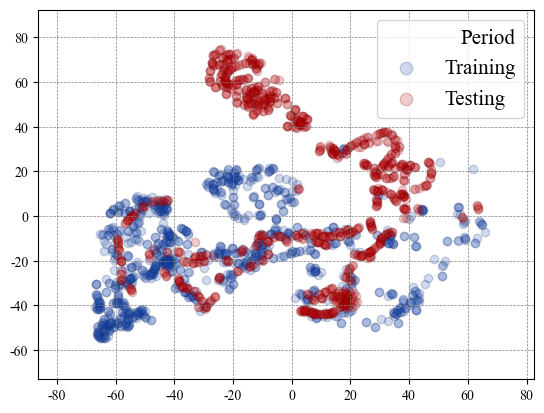

In [333]:
x_min, x_max = up_x.min(), up_x.max()
y_min, y_max = right_x.min(), right_x.max()
# plt.gca().set_facecolor('#eeeefe')
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c='#1744a8', label='Training', edgecolors='#11317c', alpha=0.2)
plt.scatter(test_tsne[:, 0], test_tsne[:, 1], c='#b90104', label='Testing', edgecolors='#7e0004', alpha=0.2)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend(title="Period", fontsize=15, markerscale=1.5, title_fontsize=15, alignment="right")
# save
plt.savefig('kde_tsne_{0}.png'.format(dataset_name), dpi=300, bbox_inches='tight')
plt.show()


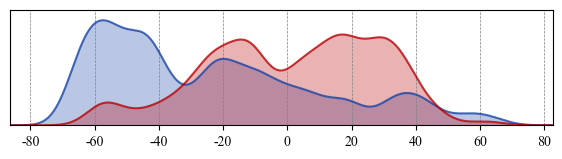

In [334]:
# plt upper kde
## set size
plt.figure(figsize=(7, 1.5))
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.plot(up_x, up_kde1, label='train', c='#1744a8', alpha=0.8)
plt.plot(up_x, up_kde2, label='test', c='#b90104', alpha=0.8)
# plt.xticks([])
plt.yticks([])
plt.xlim(x_min, x_max)
plt.ylim(0, max(max(up_kde1), max(up_kde2)) * 1.1)
plt.fill_between(x=up_x, y1=0, y2=up_kde1, facecolor='#1744a8', alpha=0.3)
plt.fill_between(x=up_x, y1=0, y2=up_kde2, facecolor='#b90104', alpha=0.3)
# save
plt.savefig('kde_tsne_{0}_up.png'.format(dataset_name), dpi=300, bbox_inches='tight')
plt.show()


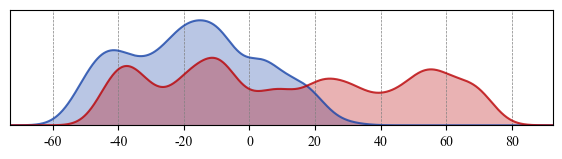

In [335]:
# plt right kde
## set size
plt.figure(figsize=(7, 1.5))
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.plot(right_x, right_kde1, label='train', c='#1744a8', alpha=0.8)
plt.plot(right_x, right_kde2, label='test', c='#b90104', alpha=0.8)
# plt.xticks([])
plt.yticks([])
plt.xlim(y_min, y_max)
plt.ylim(0, max(max(right_kde1), max(right_kde2)) * 1.1)
plt.fill_between(x=right_x, y1=0, y2=right_kde1, facecolor='#1744a8', alpha=0.3)
plt.fill_between(x=right_x, y1=0, y2=right_kde2, facecolor='#b90104', alpha=0.3)
# save
plt.savefig('kde_tsne_{0}_right.png'.format(dataset_name), dpi=300, bbox_inches='tight')
plt.show()

